In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Train Data Loading

In [2]:
train_data = pd.read_excel('../_github/Data/train_data_prob_added.xlsx')
train_data = train_data.convert_dtypes()
test_data = pd.read_excel('../_github/Data/test_data_prob_added.xlsx')
test_data = test_data.convert_dtypes()

In [3]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              36168 non-null  string 
 1   age            36168 non-null  Int64  
 2   balance        36168 non-null  Int64  
 3   day_of_month   36168 non-null  Int64  
 4   duration       36168 non-null  Int64  
 5   campaign       36168 non-null  Int64  
 6   pdays          36168 non-null  Int64  
 7   previous       36168 non-null  Int64  
 8   NB_prob        36168 non-null  Float64
 9   Logistic_prob  36168 non-null  Float64
 10  DT_prob        36168 non-null  Float64
 11  EBM_prob       36168 non-null  Float64
dtypes: Float64(4), Int64(7), string(1)
memory usage: 3.7 MB
None


In [4]:
display(train_data.head())
train_data.shape

,y,age,balance,day_of_month,duration,campaign,pdays,previous,NB_prob,Logistic_prob,DT_prob,EBM_prob
0,yes,66,2048,27,212,1,-1,0,0.2548,0.590641,0.525657,0.336438
1,no,49,181,8,161,3,-1,0,0.012788,0.184176,0.286525,0.185477
2,no,41,-129,18,176,1,-1,0,0.020337,0.460129,0.403237,0.365158
3,no,42,1316,5,285,1,-1,0,0.070662,0.283496,0.286525,0.372153
4,no,45,1621,18,122,8,-1,0,0.095399,0.416171,0.525657,0.487318


(36168, 12)

## Continuous Covariates

In [5]:
numeric_cols = ["age","balance","campaign","pdays","previous","NB_prob","Logistic_prob","DT_prob"]
X_train = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()
y_train = (train_data['y'] == "yes").astype(int)
y_test = (test_data['y'] == "yes").astype(int)

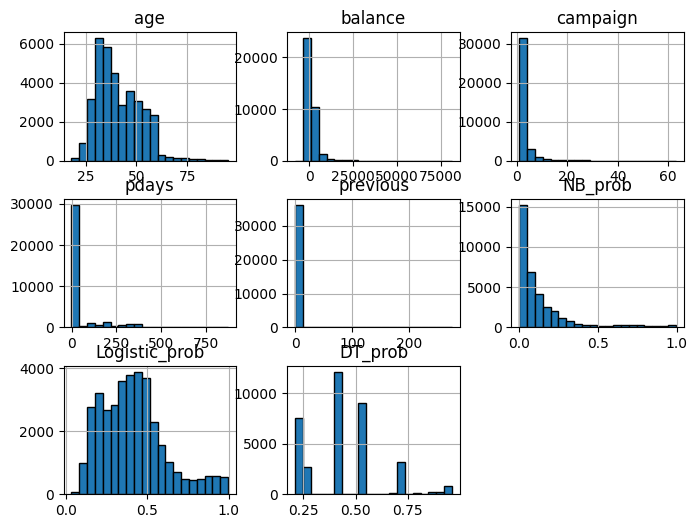

In [6]:
X_train.hist(bins = 20,edgecolor ='black',figsize=(8,6))
plt.show()

In [7]:
X_train["log_balance"] = np.sign(X_train["balance"]) * np.log1p(np.abs(X_train["balance"]))
X_train["log_previous"] = np.log1p(X_train["previous"])
X_test["log_balance"] = np.sign(X_test["balance"]) * np.log1p(np.abs(X_test["balance"]))
X_test["log_previous"] = np.log1p(X_test["previous"])

In [8]:
X_train.head()

,age,balance,campaign,pdays,previous,NB_prob,Logistic_prob,DT_prob,log_balance,log_previous
0,66,2048,1,-1,0,0.2548,0.590641,0.525657,7.625107,0.0
1,49,181,3,-1,0,0.012788,0.184176,0.286525,5.204007,0.0
2,41,-129,1,-1,0,0.020337,0.460129,0.403237,-4.867534,0.0
3,42,1316,1,-1,0,0.070662,0.283496,0.286525,7.183112,0.0
4,45,1621,8,-1,0,0.095399,0.416171,0.525657,7.391415,0.0


In [9]:
y_train.value_counts()

y
0    31936
1     4232
Name: count, dtype: int64

In [10]:
X_train = X_train.drop(["balance","previous"], axis=1)
X_test = X_test.drop(["balance","previous"], axis=1)

In [11]:
X_train.columns

Index(['age', 'campaign', 'pdays', 'NB_prob', 'Logistic_prob', 'DT_prob',
       'log_balance', 'log_previous'],
      dtype='object')

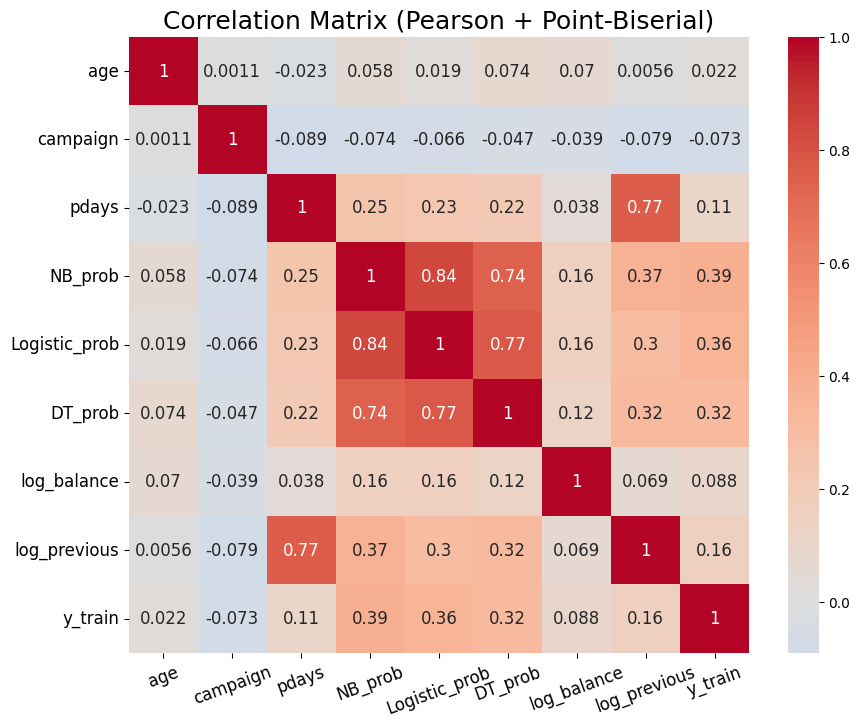

In [12]:
from scipy.stats import pointbiserialr

pb_corr = {}

for col in X_train.columns:
    r, p = pointbiserialr(y_train, X_train[col].astype(float))
    pb_corr[col] = r

pb_corr = pd.Series(pb_corr, name='y_train')

num_corr = X_train.corr()
corr = num_corr.copy()
corr['y_train'] = pb_corr
corr.loc['y_train'] = corr['y_train']
corr.loc['y_train','y_train'] = 1.0

plt.figure(figsize=(10,8))

sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=True,
    annot_kws={"size": 12}   # annotation (number) font size
)

plt.title("Correlation Matrix (Pearson + Point-Biserial)", fontsize=18)
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [13]:
# Evaluation helper
def print_metrics(y_true, y_pred, y_prob= None):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))
    if y_prob is not None:
        print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")

In [14]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0, class_weight="balanced"))
])

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print_metrics(y_test, y_pred)

Confusion Matrix:
 [[6696 1290]
 [ 478  579]]

Classification Report:
               precision    recall  f1-score   support

           0      0.933     0.838     0.883      7986
           1      0.310     0.548     0.396      1057

    accuracy                          0.804      9043
   macro avg      0.622     0.693     0.640      9043
weighted avg      0.860     0.804     0.826      9043



In [15]:
X_train.shape

(36168, 8)

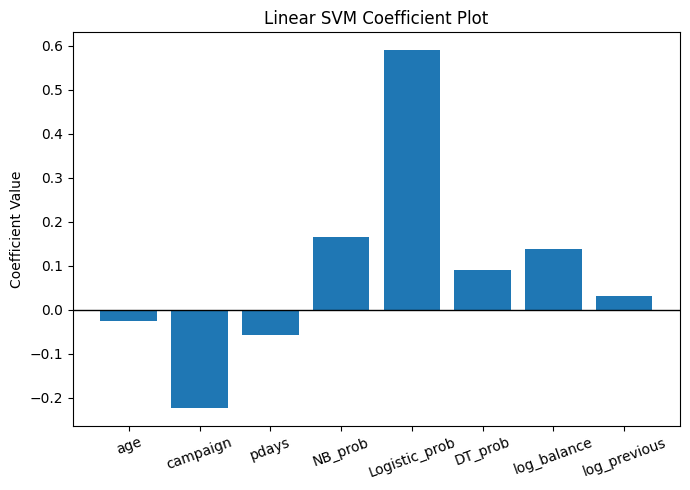

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients
coef = svm_model.named_steps["svc"].coef_[0]

plt.figure(figsize=(7,5))
plt.bar(list(X_train.columns), coef)
plt.axhline(0, color='black', linewidth=1)
plt.title("Linear SVM Coefficient Plot")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [17]:
# Coefficient vector w
w = svm_model.named_steps["svc"].coef_[0]

# Margin width
margin = 2 / np.linalg.norm(w)

print("Margin width:", margin)


Margin width: 2.954818524232521


In [ ]:
import plotly.graph_objects as go
import numpy as np

scaler = svm_model.named_steps["scaler"]
svc = svm_model.named_steps["svc"]

def plot_linear_boundary_plotly(i, j, X, y, model, save_path="plots/"):
    import os
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    var_i = X.columns[i]
    var_j = X.columns[j]

    xi = X[var_i].values
    xj = X[var_j].values

    w = model.coef_[0]
    b = model.intercept_[0]

    wi = w[i]
    wj = w[j]

    # meshgrid for shading
    x_min, x_max = xi.min() - 0.5, xi.max() + 0.5
    y_min, y_max = xj.min() - 0.5, xj.max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    zz = (wi * xx + wj * yy + b)
    
    fig = go.Figure()

    # shaded half-spaces with stronger reddish/bluish colors
    fig.add_trace(go.Contour(
        z=zz,
        x=np.linspace(x_min, x_max, 200),
        y=np.linspace(y_min, y_max, 200),
        showscale=False,
        colorscale=[[0, 'rgba(255, 100, 100,0.3)'],  # stronger red
                    [1, 'rgba(100, 150, 255,0.3)']], # stronger blue
        contours=dict(start=0, end=0, size=1),
        hoverinfo='skip',
    ))

    # decision boundary
    yy_line = -(wi / wj) * np.linspace(x_min, x_max, 200) - b / wj
    fig.add_trace(go.Scatter(
        x=np.linspace(x_min, x_max, 200),
        y=yy_line,
        mode='lines',
        line=dict(color='crimson', width=2),
        name='Decision Boundary'
    ))

    # scatter points
    fig.add_trace(go.Scatter(
        x=xi,
        y=xj,
        mode='markers',
        marker=dict(
            size=7,
            color=y,
            colorscale='Viridis',
            line=dict(width=0.5, color='white'),
            opacity=0.8
        ),
        name='Data'
    ))

    fig.update_layout(
        title=dict(
            text=f"Linear SVM Hyperplane: {var_i} vs {var_j}",
            x=0.5,
            xanchor='center',
            font=dict(size=18)
        ),
        xaxis_title=var_i,
        yaxis_title=var_j,
        template='plotly_white',
        width=700,
        height=500,
        showlegend=True,
        legend=dict(x=0.02, y=0.98, bordercolor="LightGray", borderwidth=1),
        margin=dict(l=50, r=50, t=70, b=50),
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray')
    )

    # save figure as PNG
    filename = f"{save_path}SVM_{var_i}_vs_{var_j}.png"
    fig.write_image(filename, scale=2)
    print(f"Saved: {filename}")


# loop pairs and save
for i in [1,3,4,5,6]:
    for j in [1,3,4,5,6]:
        if j > i:
            plot_linear_boundary_plotly(i, j, X_train, y_train, svc)